# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [1]:
%matplotlib inline
import tensorflow as tf
import d2l as d2l

2025-02-20 03:17:41.349492: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [3]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Flatten(input_shape=(28, 28)))  # 将输入展平为一维向量
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)  # 正态分布初始化权重
net.add(tf.keras.layers.Dense(10, kernel_initializer=weight_initializer))   # 添加全连接层，输出10个类别

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [4]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [5]:
trainer = tf.keras.optimizers.SGD(learning_rate=.1)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


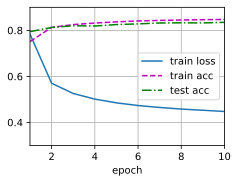

In [6]:
%matplotlib inline
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

和以前一样，这个算法使结果收敛到一个相当高的精度，而且这次的代码比之前更精简了。

## 小结

* 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
* 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。

## 练习

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果。
1. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题？


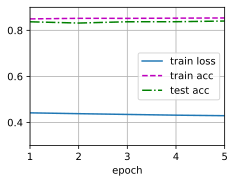

In [7]:
# 练习 1
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
num_epochs = 5
trainer = tf.keras.optimizers.SGD(learning_rate=.05)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

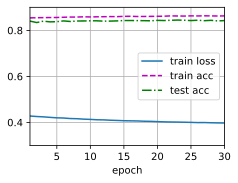

In [8]:
# 练习 2
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
num_epochs = 30
trainer = tf.keras.optimizers.SGD(learning_rate=.1)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

这里没有明显下降，可能是因为我们的迭代器之类的已经通过打乱训练集顺序之类的操作进行了一定程度的输入优化。但是如果测试集的准确性下降，有以下可能：

+ 过拟合：随着训练时间增加，模型过度记忆训练数据细节，导致泛化能力下降
+ 优化停滞：固定学习率可能导致后期在最优解附近震荡
+ 模型复杂度不匹配：简单线性模型难以捕获深层特征

另外，直接在Pycharm内运行执行train_ch3函数的block时，图片可能无法正确显示，此时直接在远程Jupyter Notebook的网页上重启内核运行可以显示。

[Discussions](https://discuss.d2l.ai/t/1792)
